In [5]:
!git pull

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 3), reused 6 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 637 bytes | 3.00 KiB/s, done.
From https://github.com/OfirShechter/object-detection-nn
   a4b474f..7e6704f  part_2     -> origin/part_2
Updating a4b474f..7e6704f
Fast-forward
 nn/YOLO_VGG16/utils/helpers.py | 11 +++++++----
 1 file changed, 7 insertions(+), 4 deletions(-)


In [2]:
pwd

'/home/dcor/niskhizov/Rar'

In [3]:
# cd ../../..

In [4]:
cd object-detection-nn

/home/dcor/niskhizov/Rar/object-detection-nn


In [6]:
import sys
import os

from nn.YOLO_VGG16.utils.constants import ANCHORS
from nn.YOLO_VGG16.prepare_data.coco_dataset import CocoDataset
from nn.YOLO_VGG16.prepare_data.transforms import test_transform
from nn.YOLO_VGG16.utils.helpers import convert_cells_to_bboxes, get_coco_index_lable_map, load_checkpoint, nms, plot_image
from nn.YOLO_VGG16.utils.constants import device, s, leanring_rate, checkpoint_file
from nn.YOLO_VGG16.model.YOLO_VGG16 import YOLO_VGG16
import torch
import torch.optim as optim
from nn.YOLO_VGG16.model.loss import YOLOLoss
from pycocotools.coco import COCO

/home/dcor/niskhizov/anaconda3/envs/obj_d/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [20]:
model_path = "/home/dcor/niskhizov/Rar/object-detection-nn/nn/YOLO_VGG16/degug_notebooks/vgg_r_model" + f"e12_vgg16_{checkpoint_file}"
# model_path = "nn/YOLO_VGG16/degug_notebooks/" + f"e11_vgg16_{checkpoint_file}"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"{model_path} not found")

In [8]:
coco_path = '/home/dcor/niskhizov/Rar/object-detection-nn/nn/YOLO_VGG16/degug_notebooks/temp/instances_val2017.json'
# coco_path = 'nn/cocodataset/annotations/instances_val2017.json'
coco = COCO(coco_path)
categories = ["dog"]

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


In [9]:
# Setting the load_model to True 
load_model = True
  
# Defining the model, optimizer, loss function and scaler 
model = YOLO_VGG16(num_classes=len(categories)).to(device) 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
loss_fn = YOLOLoss() 
scaler = torch.amp.GradScaler(device=device) 

In [21]:
# Loading the checkpoint 
if load_model: 
    load_checkpoint(model_path, model, optimizer, leanring_rate, device) 


==> Loading checkpoint


In [11]:
dataset = CocoDataset( 
	coco_obj=coco, 
	categories=categories,
	grid_sizes=[13, 26, 52], 
	anchors=ANCHORS, 
	transform=test_transform 
) 

# Defining the train data loader 
test_loader = torch.utils.data.DataLoader( 
	dataset=dataset, 
	batch_size=1, 
	shuffle=True, 
) 
anchors = ( 
            torch.tensor(ANCHORS) 
                * torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
            ).to(device) 
model.eval() 

# Getting a sample image from the test data loader 
x, y = next(iter(test_loader)) 
x = x.to(device) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


model ran successfully
cell converted to boxes


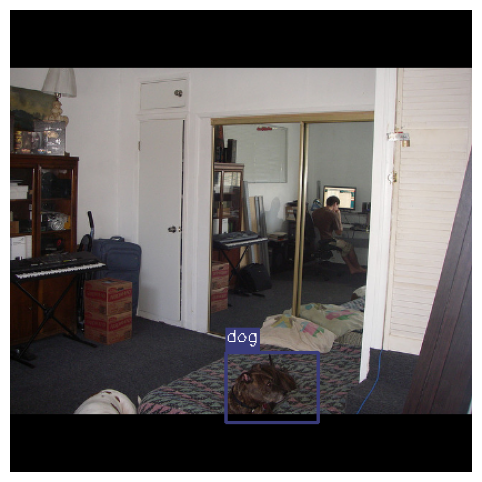

In [23]:
# x, y = next(iter(test_loader)) 
# x = x.to(device) 

with torch.no_grad(): 
    # Getting the model predictions 
    output = model(x) 
    print('model ran successfully')
    # Getting the bounding boxes from the predictions 
    bboxes = [[] for _ in range(x.shape[0])] 
  
    # Getting bounding boxes for each scale 
    for i in range(3): 
        batch_size, A, S, _, _ = output[i].shape 
        anchor = anchors[i] 
        boxes_scale_i = convert_cells_to_bboxes( 
                            output[i], anchor, s=S, is_predictions=True
                        ) 
        for idx, (box) in enumerate(boxes_scale_i): 
            bboxes[idx] += box 

print("cell converted to boxes")
# Plotting the image with bounding boxes for each image in the batch 
for i in range(batch_size): 
    # Applying non-max suppression to remove overlapping bounding boxes 
    nms_boxes = nms(bboxes[i], iou_threshold=0.1, threshold=0.8) 
    
    # Plotting the image with bounding boxes 
    plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes, categories)


In [12]:
# scaled_anchors = ( 
# 	torch.tensor(ANCHORS) *
# 	torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
# ).to(device) 

In [13]:
# loss_fn(output[0], output[0],scaled_anchors[0])

In [14]:
# sigmoid = torch.nn.Sigmoid()

In [15]:
# obj = sigmoid(output[0][..., 0]) == 1
# no_obj = sigmoid(output[0][..., 0]) == 0

# # print numbers of object and no object
# print("Number of object predictions: ", obj.sum().item())
# print("Number of no object predictions: ", no_obj.sum().item())

In [16]:
# sigmoid(output[0][..., 0])